# Sports Action Recognition Using CNN-RNN Architecture on `UCF101 10 Sports actions` (Scratch)

## Dependencies

In [20]:
!pip install -U pydot graphviz --quiet

In [22]:

import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import clear_output
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import pad_sequences, plot_model
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
import kagglehub
from tqdm import tqdm

In [ ]:
MODEL_NAME = "slow_fusion_ucf101_10c"

BATCHT_SIZE = 10
EPOCHS = 100

Save versioned model

In [ ]:
base_dir = "../models"
pattern = re.compile(rf"{MODEL_NAME}_v(\d+)\.keras")

existing_versions = [
    int(pattern.search(f).group(1)) 
    for f in os.listdir(base_dir) if pattern.search(f)
]
version = max(existing_versions, default=0) + 1
MODEL_PATH = os.path.join(base_dir, f"{MODEL_NAME}_v{version}.keras")

print(f"Model will be saved to: {MODEL_PATH}")

Model will be saved to: ../../models/cnn_rnn_ucf101_v1.keras


## Data Loading

In [ ]:
path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

print("Path to dataset files:", path)
train_df = pd.read_csv(path+"/train.csv")
# train_df["label"].unique()

Path to dataset files: /Users/mzitoh/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4


array(['Swing', 'SkyDiving', 'BreastStroke', 'TableTennisShot',
       'FloorGymnastics', 'Rowing', 'SoccerJuggling', 'BenchPress',
       'TennisSwing', 'FrisbeeCatch', 'Kayaking', 'ApplyLipstick',
       'RopeClimbing', 'JumpingJack', 'BlowingCandles', 'BabyCrawling',
       'HammerThrow', 'BoxingPunchingBag', 'Skiing', 'UnevenBars',
       'PullUps', 'RockClimbingIndoor', 'HeadMassage', 'HulaHoop',
       'Rafting', 'ShavingBeard', 'LongJump', 'FieldHockeyPenalty',
       'VolleyballSpiking', 'Punch', 'Archery', 'PlayingDhol',
       'CleanAndJerk', 'PlayingDaf', 'GolfSwing', 'PlayingSitar',
       'IceDancing', 'SkateBoarding', 'BodyWeightSquats',
       'HandstandPushups', 'BalanceBeam', 'WallPushups', 'HorseRiding',
       'Bowling', 'JumpRope', 'CuttingInKitchen', 'CliffDiving',
       'PlayingGuitar', 'FrontCrawl', 'HandstandWalking', 'Fencing',
       'Basketball', 'Typing', 'TaiChi', 'PlayingCello', 'Lunges',
       'Shotput', 'Nunchucks', 'ApplyEyeMakeup', 'BaseballPitch',
 

#Check all 10 classes to verify if data exists for each class

In [ ]:
ucf10Classes=["Diving",
"GolfSwing",
"SoccerPenalty",
"BenchPress",
"HorseRiding",
"Biking",
"SkateBoarding",
"Swing",
"TennisSwing",
"HandstandWalking"]

for _class in ucf10Classes:
    print(_class,len(train_df[train_df['label']==_class]))


Diving 112
GolfSwing 104
SoccerPenalty 102
BenchPress 120
HorseRiding 123
Biking 100
SkateBoarding 90
Swing 98
TennisSwing 124
HandstandWalking 83


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
content = []

sample = 50

for _class in ucf10Classes:
  content.extend(train_df[train_df['label']==_class].sample(sample).values)


content = np.array(content)
len(content)
content[51]

array(['v_GolfSwing_g01_c05', '/train/GolfSwing/v_GolfSwing_g01_c05.avi',
       'GolfSwing'], dtype=object)

In [9]:
content[450]

array(['v_HandstandWalking_g16_c01',
       '/train/HandstandWalking/v_HandstandWalking_g16_c01.avi',
       'HandstandWalking'], dtype=object)

In [10]:
# content = content.reshape(500,)
x = content[:,1]
x_name = content[:,0]
y = content[:,2]
y[0],x[0], x_name[0], y[50], x[50]

('Diving',
 '/train/Diving/v_Diving_g01_c02.avi',
 'v_Diving_g01_c02',
 'GolfSwing',
 '/train/GolfSwing/v_GolfSwing_g16_c03.avi')

#Frame Reader

In [11]:
def read_frames(root_folder,arr,each_nth=10):
    videos=[]
    for _content  in tqdm(arr):
        clear_output()
        vcap=cv2.VideoCapture(f"{root_folder}/{_content}")
        success=True
        frames=[]
        cnt=0
        while success:
            try:
              success,image=vcap.read()
              cnt+=1
              if cnt%each_nth==0:
                image=resize(image,(128,192))
                # imshow(image)
                frames.append(image)
            except Exception as e:
                print(e)
        videos.append(frames)
    return videos

In [12]:
X_frames = read_frames(path,x)

100%|██████████| 500/500 [01:00<00:00,  8.33it/s]


## Data Preprocessing

In [13]:
X_padded_frames = pad_sequences(X_frames, maxlen=30, dtype='float32', padding='post', truncating='post', value=0.0)

In [14]:
# Create a StringLookup layer
lookup = tf.keras.layers.StringLookup(vocabulary=ucf10Classes, num_oov_indices=0, output_mode="one_hot")
y_np = lookup(y).numpy()

In [15]:
# Split the data into training and temporary (test + validation) sets
x_train, x_temp, y_train, y_temp = train_test_split(
    X_padded_frames, y_np, test_size=0.3, random_state=42, shuffle=True
)

# Split the temporary set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")

Training set: (350, 30, 128, 192, 3), (350, 10)
Validation set: (75, 30, 128, 192, 3), (75, 10)
Test set: (75, 30, 128, 192, 3), (75, 10)


Review random video

30


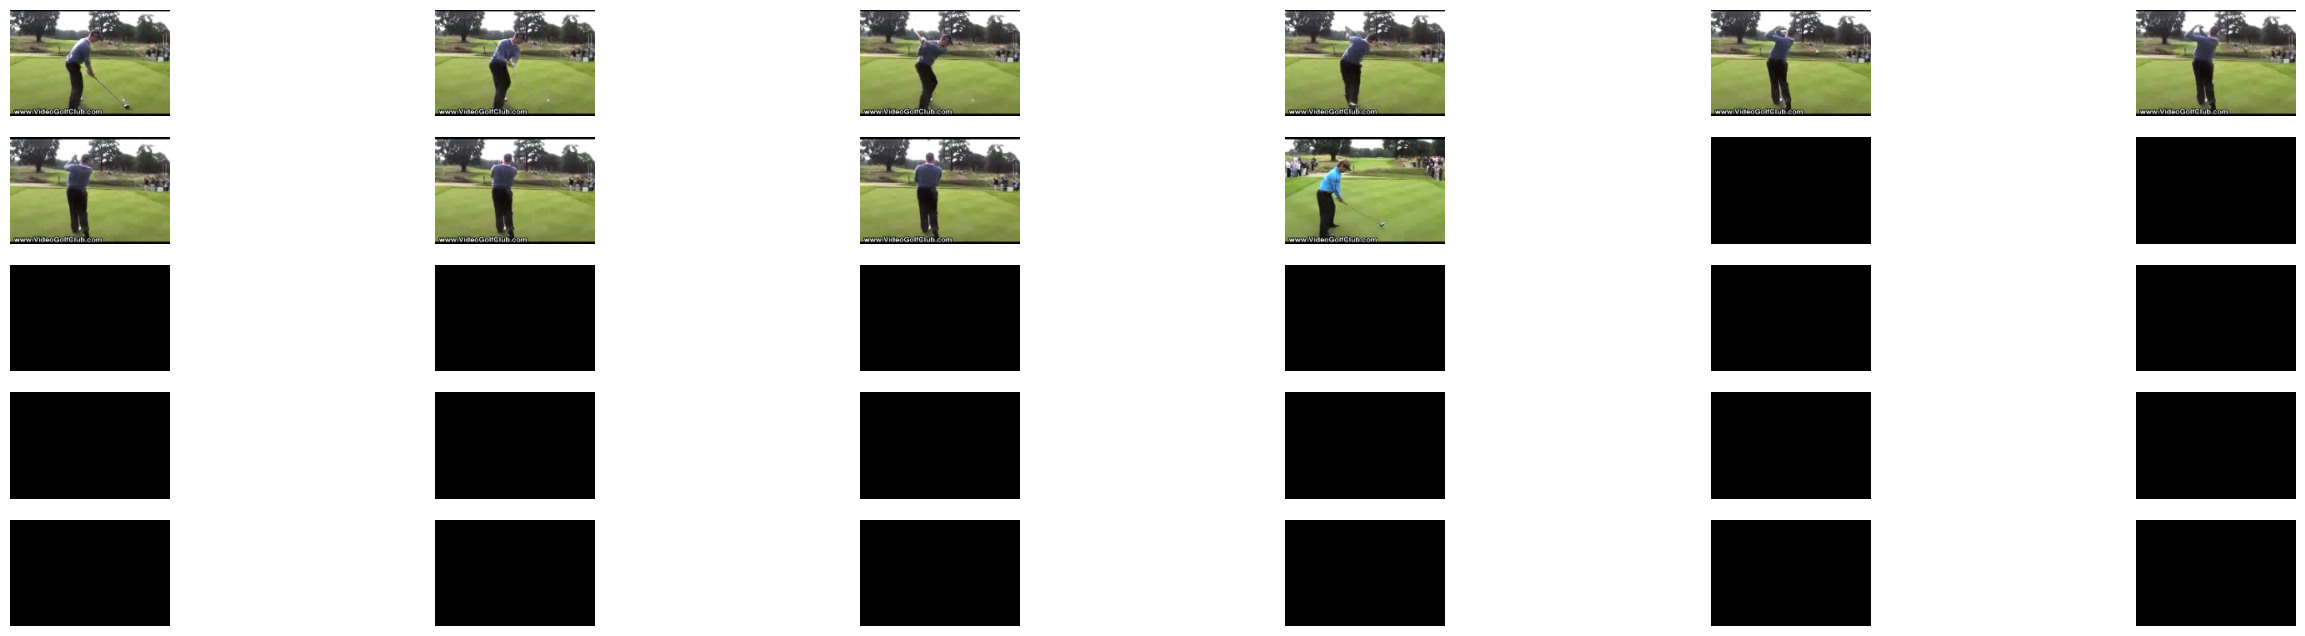

In [16]:
fig = plt.figure(figsize=(32,8))

random_video_index = np.random.randint(0, len(X_padded_frames))

print(len(X_padded_frames[random_video_index]))

for i, image in enumerate(X_padded_frames[random_video_index]):
    ax = plt.subplot(5, 6, i+1)
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.axis('off')

plt.show()

In [17]:
def list_to_stack(xs):
  xs=tf.stack(xs, axis=1)
  s = tf.shape(xs)

  return xs

## Model Architecture

In [ ]:
ish=(30, 128, 192, 3)
target_shape=(10,32*48*50)

xs=[]

inp = Input(ish)

for slice_indx in range(0,10,1):
  x=Lambda(lambda x: x[:, slice_indx])(inp)
  x=BatchNormalization(momentum=0.8)(x)
  x=Conv2D(filters=20, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)

  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)

  xs.append(x)


t=Lambda(list_to_stack)(xs)
t=Conv3D(50,3,padding='same')(t)
t=BatchNormalization(momentum=0.8)(t)
t=Reshape(target_shape)(t)
t=GRU(25, return_sequences=True)(t)
t=GRU(50, return_sequences=False,dropout=0.5)(t)

t=Dense(100,'relu')(t)
out=Dense(10, activation='softmax')(t)

model = Model(inputs=inp, outputs=out)
opt = tf.keras.optimizers.SGD(learning_rate=0.0087)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 128,   │          0 │ -                 │
│ (InputLayer)        │ 192, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 192,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 192,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128, 192,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128, 192,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 128, 192,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 128, 192,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 128, 192,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 128, 192,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 128, 192,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 128, 192,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 192,  │         12 │ lambda[0][0]      │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_1[0][0]    │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_2[0][0]    │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_3[0][0]    │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_4[0][0]    │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_5[0][0]  

 Total params: 5,963,755 (22.75 MB)

 Trainable params: 5,962,595 (22.75 MB)

 Non-trainable params: 1,160 (4.53 KB)

In [38]:
# MODEL_ARCHITECTURE_PATH = MODEL_PATH.replace('.keras', '_architecture.png')
# plot_model(model, to_file=MODEL_ARCHITECTURE_PATH, show_shapes=True, show_layer_names=True)

# print(f"Model architecture saved to: {MODEL_ARCHITECTURE_PATH}")

## Model Training

In [39]:
checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor="val_loss",
    mode="min",  # Save the model when the loss decreases (when model improves)
    save_weights_only=False,
    save_best_only=True,
    verbose=1,
)

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCHT_SIZE,
    shuffle=True,
    callbacks=[checkpoint],
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.1315 - loss: 2.2975
Epoch 1: val_loss improved from inf to 2.13354, saving model to ../../models/cnn_rnn_ucf101_v1.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1318 - loss: 2.2961 - val_accuracy: 0.3333 - val_loss: 2.1335
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.2832 - loss: 2.0808
Epoch 2: val_loss improved from 2.13354 to 1.98817, saving model to ../../models/cnn_rnn_ucf101_v1.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 976ms/step - accuracy: 0.2837 - loss: 2.0805 - val_accuracy: 0.4800 - val_loss: 1.9882
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.4180 - loss: 1.9779
Epoch 3: val_loss improved from 1.98817 to 1.92268, saving model to ../../models/cnn_rnn_ucf101_v1.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 977ms/step - accuracy: 0.4177 - loss: 1.9772 - val_accuracy: 0.4267 - val_loss: 1.9227
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - accuracy: 0.5050 - los

In [40]:
if os.path.exists(MODEL_PATH):
    print(f"Model saved at: {MODEL_PATH}")
    model_size = os.path.getsize(MODEL_PATH) / (1024 * 1024)
    print(f"Model size: {model_size:.2f} MB")
else:
    print("Model file not found.")

Model saved at: ../../models/cnn_rnn_ucf101_v1.keras
Model size: 23.09 MB


## Training Metrics

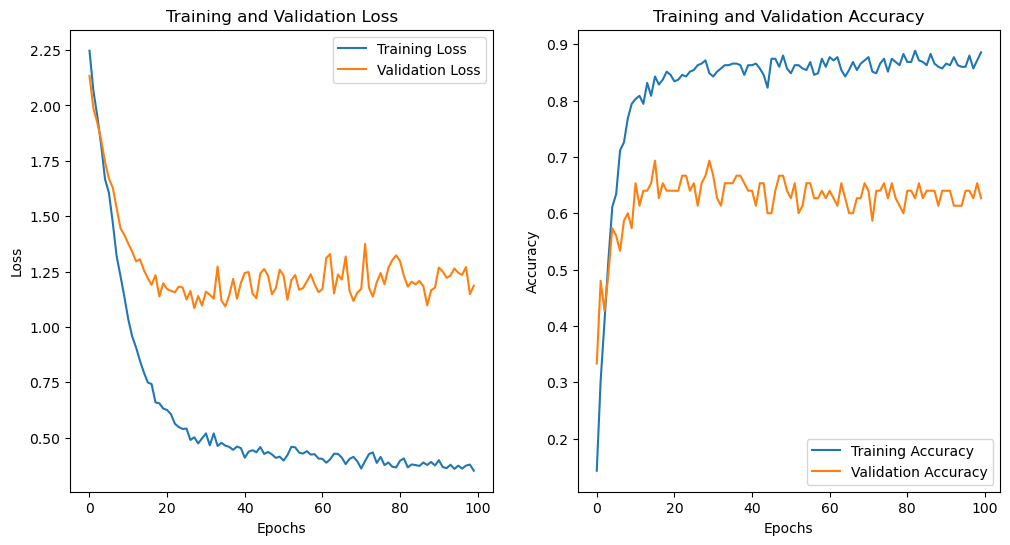

In [41]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
plt.close()

## Model Evaluation & Testing

In [42]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=BATCHT_SIZE)

print(f"Test Loss: {loss :.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.5985 - loss: 1.6215
Test Loss: 1.7709
Test Accuracy: 56.00%


In [43]:
classes = {content[i][1].split("/")[2] for i in range(len(content))}
class_map = dict(enumerate(classes))
class_map

{0: 'Diving',
 1: 'SkateBoarding',
 2: 'HorseRiding',
 3: 'HandstandWalking',
 4: 'SoccerPenalty',
 5: 'TennisSwing',
 6: 'GolfSwing',
 7: 'Biking',
 8: 'BenchPress',
 9: 'Swing'}

In [44]:
sample_size = 20

In [45]:
random_videos = np.random.randint(0, len(x_test), size=(sample_size))

predicted = model.predict(x_test[random_videos], batch_size=32)
predicted = np.argmax(predicted, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


Process videos and collect frames with true and predicted labels

In [46]:
true_labels = []
pred_labels = []
frames = []  # Store frames to plot later

for i, rand_indx in enumerate(random_videos):
    video = x_test[rand_indx]
    frame = video[np.random.randint(0, 10)]

    # Ensure the frame is in uint8 format
    if frame.dtype != np.uint8:
        frame = (frame * 255).astype(np.uint8)

    # Convert the frame to RGB format
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(rgb_frame)  # Store the processed frame

    # Extract true and predicted labels
    true_label = np.argmax(y_test[rand_indx])  # One-hot encoded array
    true_labels.append(true_label)
    pred_labels.append(predicted[i])


Plot frames with titles showing true and predicted classes

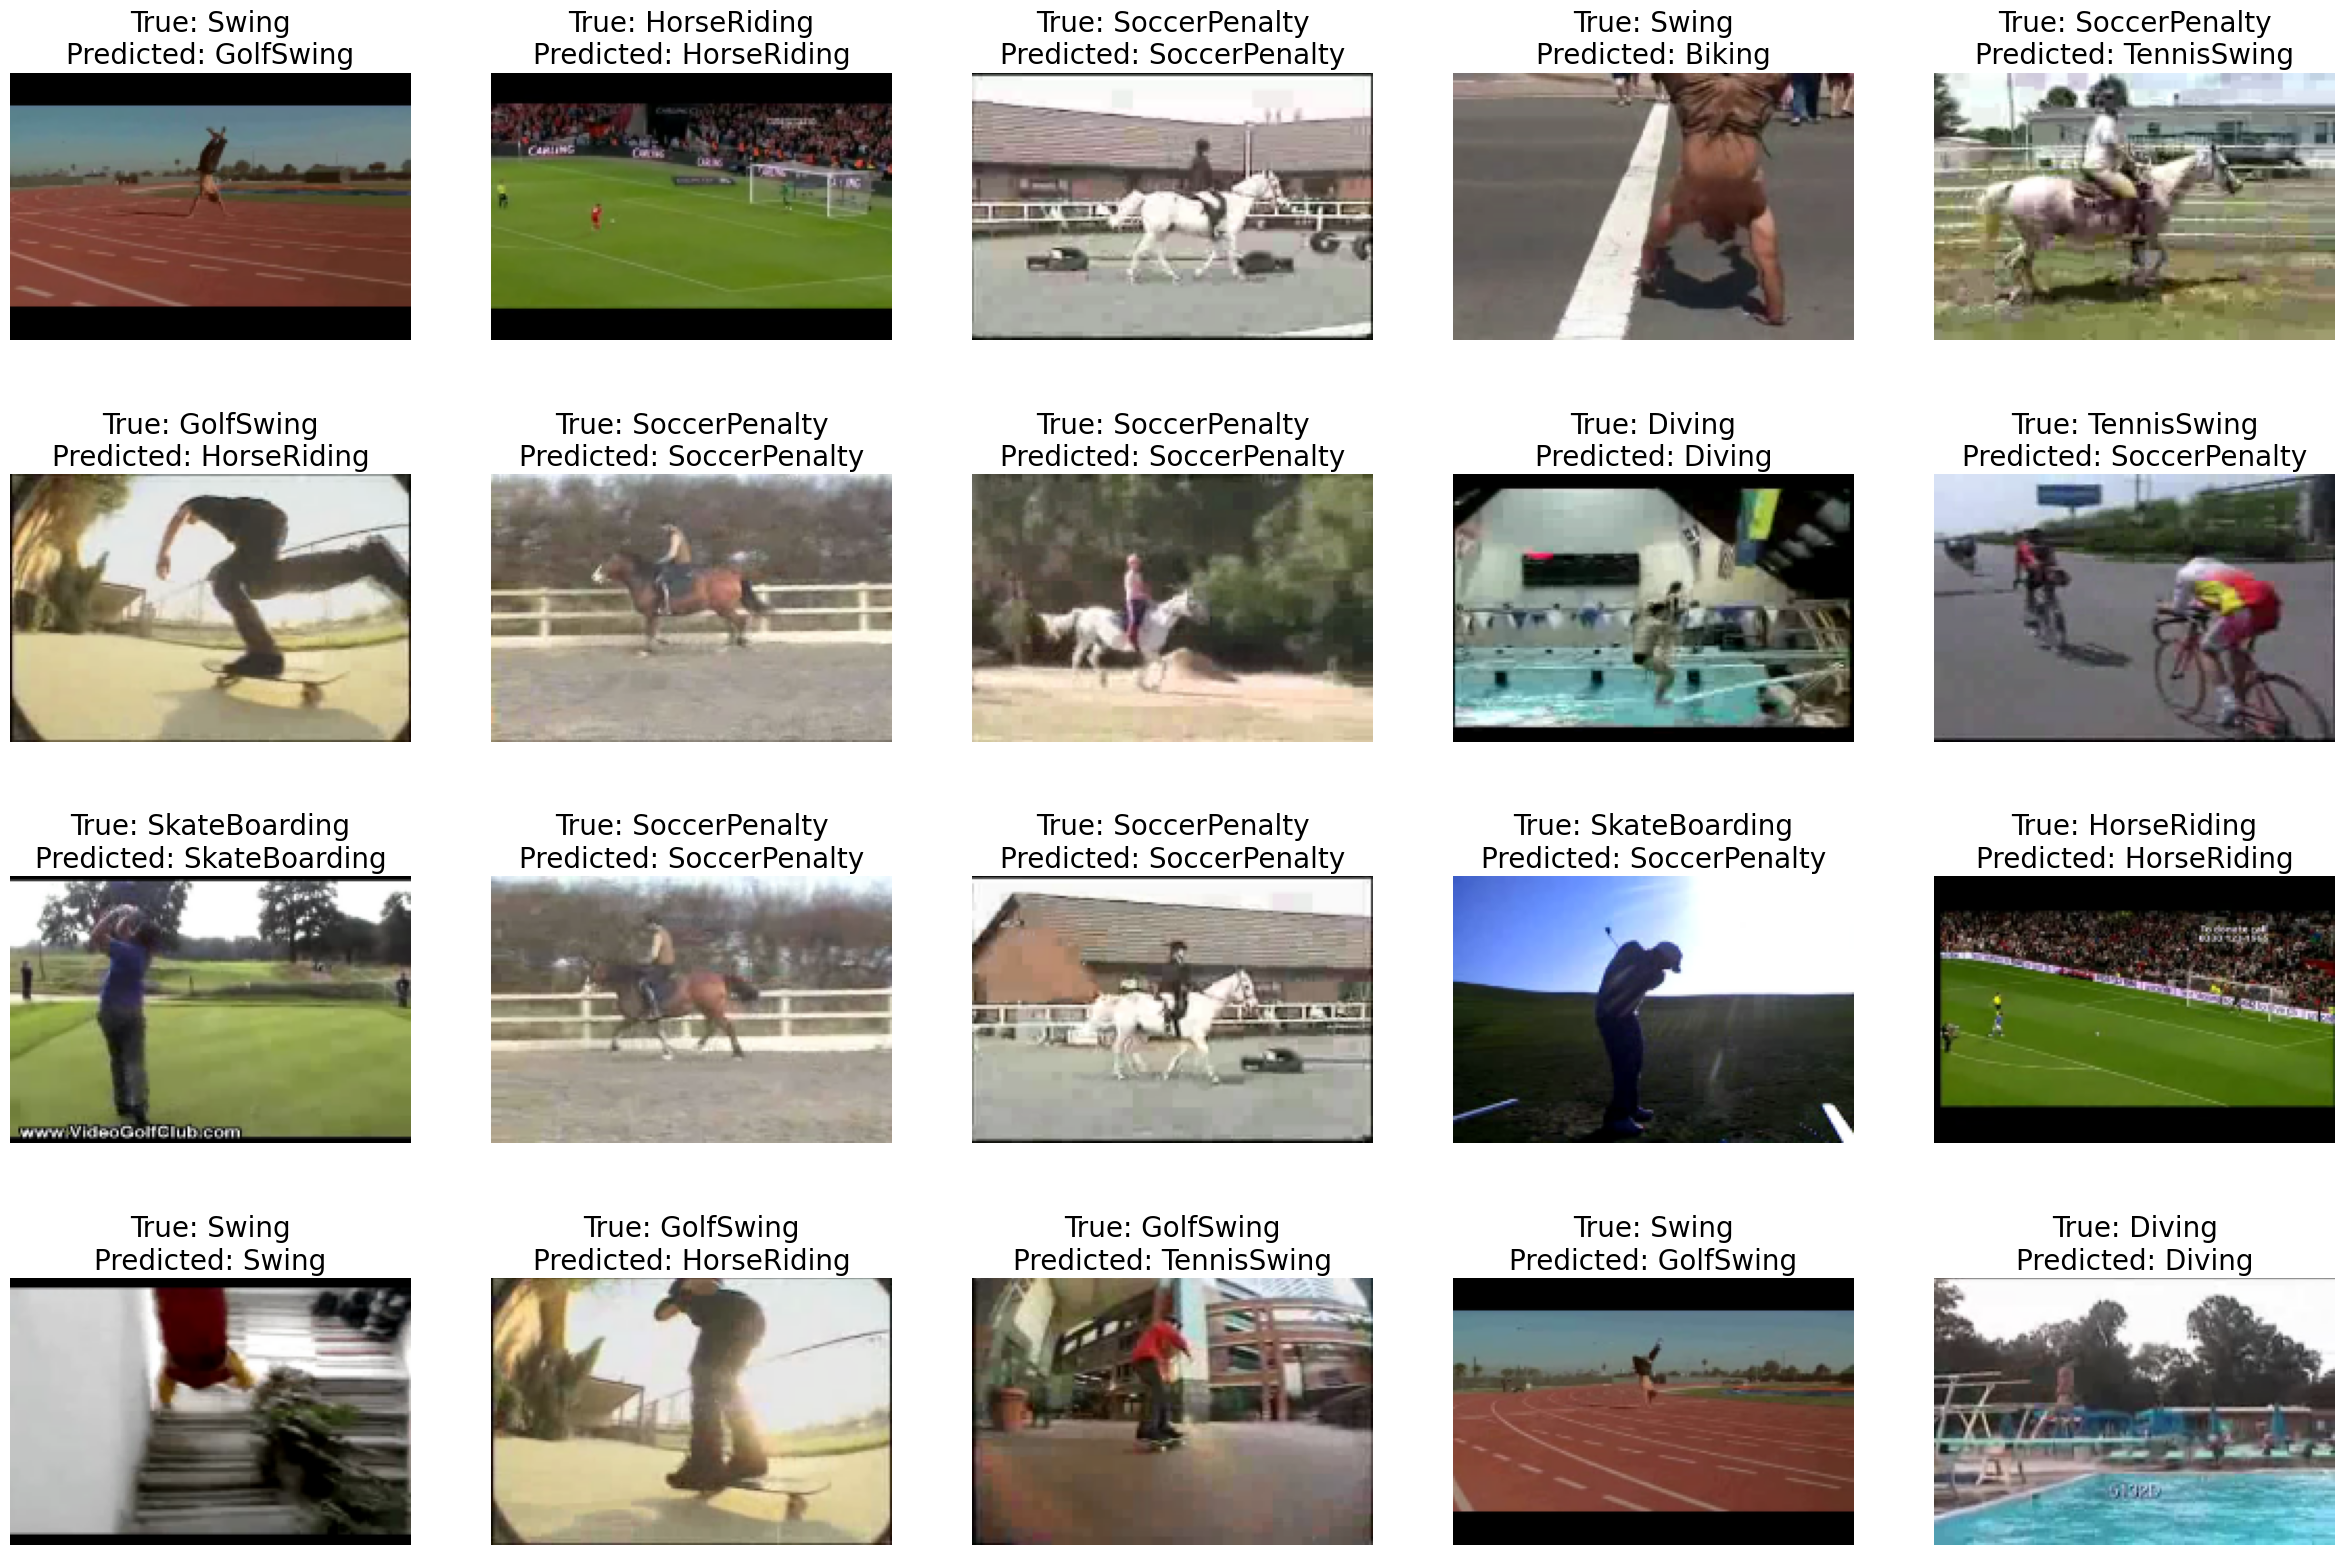

In [47]:
fig = plt.figure(figsize=(30, sample_size))

for i in range(len(frames)):
    true_class = class_map[int(true_labels[i])]
    predicted_class = class_map[pred_labels[i]]

    ax = plt.subplot(int(sample_size/5), 5, i + 1)
    ax.set_title(f"True: {true_class}\nPredicted: {predicted_class}", fontsize=20)
    plt.imshow(frames[i])
    plt.axis('off')

plt.show()
plt.close()

Classification Report

In [48]:
unique_classes = sorted(set(true_labels + pred_labels)) 
filtered_class_map = {k: v for k, v in class_map.items() if k in unique_classes}
filtered_target_names = list(filtered_class_map.values())

report = classification_report(true_labels, pred_labels, zero_division=0, labels=unique_classes, target_names=filtered_target_names)
print(report)


               precision    recall  f1-score   support

       Diving       1.00      1.00      1.00         2
SkateBoarding       1.00      0.50      0.67         2
  HorseRiding       0.50      1.00      0.67         2
SoccerPenalty       0.71      0.83      0.77         6
  TennisSwing       0.00      0.00      0.00         1
    GolfSwing       0.00      0.00      0.00         3
       Biking       0.00      0.00      0.00         0
        Swing       1.00      0.25      0.40         4

     accuracy                           0.55        20
    macro avg       0.53      0.45      0.44        20
 weighted avg       0.66      0.55      0.54        20

